In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 36.95 MiB/s, done.
Resolving deltas: 100% (2657/2657), done.
Updating files: 100% (248/248), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
image_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi",
)
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [4]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [5]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
    ]
)
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [6]:
# Set the batch size
BATCH_SIZE = (
    32  # this is lower than the ViT paper but it's because we're starting small
)

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,  # use manually created transforms
    batch_size=BATCH_SIZE,
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78aed9901580>,
 ['pizza', 'steak', 'sushi'])

In [7]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


(torch.Size([3, 224, 224]), tensor(2))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

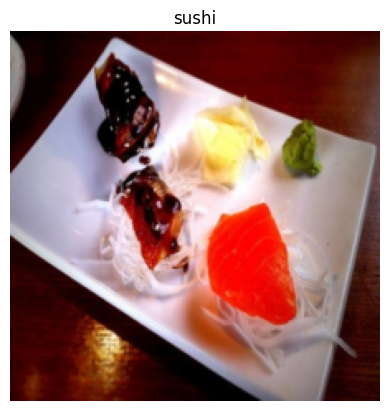

In [8]:
plt.imshow(
    image.permute(1, 2, 0)
)  # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)

In [9]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height * width) / patch_size**2)

In [10]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(embedding_layer_input_shape)
print(embedding_layer_output_shape)

(224, 224, 3)
(196, 768)


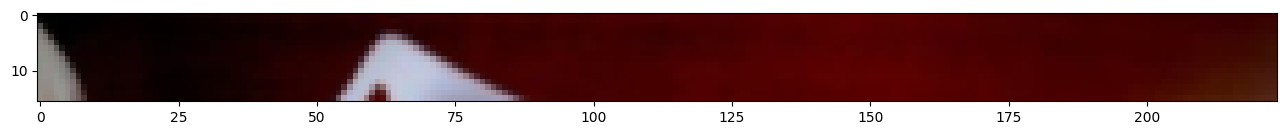

In [11]:
image_permuted = image.permute(1, 2, 0)
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:16, :, :])

In [12]:
def patchifying(img):
    img_size = 224
    patch_size = 16
    image_permuted = img.permute(1, 2, 0)

    fig, axs = plt.subplots(
        nrows=img_size // patch_size,
        ncols=img_size // patch_size,
        sharex=True,
        sharey=True,
    )

    counter = 0
    next_patch_size_length = patch_size
    while next_patch_size_length <= image_permuted.shape[0]:
        next_patch_size_width = patch_size
        while next_patch_size_width <= image_permuted.shape[1]:
            ax = axs.flat[counter]
            ax.imshow(
                image_permuted[
                    next_patch_size_length - patch_size:next_patch_size_length,
                    next_patch_size_width - patch_size:next_patch_size_width,
                    :,
                ]
            )
            ax.set_xlabel(counter + 1)
            ax.set_xticks([])
            ax.set_yticks([])
            next_patch_size_width += patch_size
            counter += 1
        next_patch_size_length += patch_size


In [13]:
# patchifying(image)

In [14]:
class PatchEmbedding(nn.Module):
    def __init__(self, channel_size=3, patch_size=16, embed_dim=768) -> None:
        super().__init__()

        self.patch_size = patch_size
        self.channel_size = channel_size
        self.embed_dim = embed_dim

        self.conv = nn.Conv2d(
            in_channels=channel_size,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0
        )
        self.flattening = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        b, c, h, w = x.shape
        assert c == self.channel_size, f"Expected {self.channel_size} channels, got {c}"
        assert h % self.patch_size == 0 and w % self.patch_size == 0, "Image size not divisible by patch size"

        patches = self.conv(x)  # [B, embed_dim, H/patch, W/patch]
        patches = self.flattening(patches).transpose(1, 2)  # [B, num_patches, embed_dim]
        return patches

In [15]:
model = PatchEmbedding()
patch_embedded_image = model(image.unsqueeze(0))

In [16]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [17]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [18]:
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)

In [19]:
class_token.shape

torch.Size([1, 1, 768])

In [20]:
patch_embedded_image_with_class_embedding = torch.cat(
    (class_token, patch_embedded_image), dim=1
)

In [21]:
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [22]:
patch_embedded_image_with_class_embedding

tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [-3.5008e-02, -3.6227e-01, -2.3166e-01,  ..., -6.5489e-02,
           2.1058e-01,  8.9774e-02],
         [-3.4801e-03,  6.2931e-04,  3.7014e-02,  ...,  2.3580e-02,
           1.5041e-02,  2.4810e-02],
         ...,
         [ 2.7927e-01, -4.9716e-01, -6.5426e-02,  ...,  3.6782e-02,
           4.8284e-01,  2.4470e-03],
         [ 2.0259e-02, -6.8218e-02,  3.1692e-02,  ...,  2.5741e-02,
           6.4810e-02, -1.8050e-02],
         [ 7.5301e-02, -4.3917e-02,  6.6635e-02,  ...,  3.1944e-02,
           2.9524e-02,  1.9065e-02]]], grad_fn=<CatBackward0>)

In [23]:
number_of_patches = int((height * width) / patch_size**2)

embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

position_embedding = nn.Parameter(
    torch.ones(1, number_of_patches + 1, embedding_dimension), requires_grad=True
)  

In [24]:
set_seeds()
patch_size = 16
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

patch_embedding_layer = PatchEmbedding(
    channel_size=3, patch_size=patch_size, embed_dim=768
)
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(
    torch.ones(batch_size, 1, embedding_dimension), requires_grad=True
) 
print(f"Class token embedding shape: {class_token.shape}")

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(
    torch.ones(1, number_of_patches + 1, embedding_dimension), requires_grad=True
) 

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


In [25]:
# patch_and_position_embedding_normalized = nn.LayerNorm(patch_and_position_embedding)

class MutliSelfAttentionBlock(nn.Module):

    def __init__(self, embedding_dim=768, nhead=3, dropout=0.0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(
            normalized_shape=embedding_dim, eps=1e-5, elementwise_affine=True
        )
        self.attn = nn.MultiheadAttention(
            embedding_dim, nhead, dropout=dropout, batch_first=True
        )

    def forward(self, x):
        attn_output, _ = self.attn(self.layer_norm(x), self.layer_norm(x), self.layer_norm(x), need_weights=False)
        return attn_output

mutli_head = MutliSelfAttentionBlock()

In [26]:
patch_and_position_embedding.shape, mutli_head(patch_and_position_embedding).shape

(torch.Size([1, 197, 768]), torch.Size([1, 197, 768]))

In [27]:
class MLPBlock(nn.Module):

    def __init__(self,
                 embedding_dim:int=768, 
                 mlp_size:int=3072,
                 dropout:float=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(
            normalized_shape=embedding_dim, eps=1e-5, elementwise_affine=True
        )
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.mlp(self.layer_norm(x))

In [28]:
mlp_model = MLPBlock()
mlp_model(mutli_head(patch_and_position_embedding))

tensor([[[-0.1249, -0.0396,  0.2644,  ..., -0.0890, -0.1273,  0.3050],
         [-0.0250,  0.0168,  0.2222,  ..., -0.0000, -0.1173,  0.2679],
         [-0.0825, -0.0971,  0.2326,  ..., -0.1610, -0.1502,  0.3558],
         ...,
         [-0.0815, -0.1143,  0.2360,  ..., -0.0142, -0.1644,  0.1578],
         [-0.1233, -0.0000,  0.1871,  ...,  0.0121, -0.1849,  0.2380],
         [-0.1465, -0.0350,  0.1590,  ...,  0.0274, -0.0415,  0.2897]]],
       grad_fn=<MulBackward0>)

In [29]:
class TransformerEncoderBlock(nn.Module):
    def __init__(
        self,
        embedding_dim: int = 768,
        num_heads: int = 12, 
        mlp_size: int = 3072,  
        mlp_dropout: float = 0.1, 
        attn_dropout: float = 0,
    ): 
        super().__init__()
        self.msa_block = MutliSelfAttentionBlock(
            embedding_dim=embedding_dim, nhead=num_heads, dropout=attn_dropout
        )

        self.mlp_block = MLPBlock(
            embedding_dim=embedding_dim, mlp_size=mlp_size, dropout=mlp_dropout
        )

    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x

        return x

In [30]:
transformer = TransformerEncoderBlock()
transformer(patch_and_position_embedding)

tensor([[[ 1.7250,  2.2186,  1.3927,  ...,  2.3467,  1.5913,  2.7369],
         [ 0.7718,  1.0642,  0.1762,  ...,  1.1413,  0.5832,  1.9106],
         [ 0.6471,  1.1939,  0.2820,  ...,  1.4559,  0.7268,  1.8122],
         ...,
         [ 0.2725,  1.0758, -0.0731,  ...,  1.4570,  0.2722,  1.8442],
         [ 0.7304,  1.2688,  0.2872,  ...,  1.2955,  0.4694,  1.6890],
         [ 0.7357,  1.1531,  0.2458,  ...,  1.3720,  0.5844,  1.7331]]],
       grad_fn=<AddBackward0>)

In [31]:
from torchinfo import summary

summary(model=transformer,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MutliSelfAttentionBlock (msa_block)              [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        (recursive)          True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        (recursive)          True
│    └─MultiheadAttention (attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)              

In [32]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)

In [34]:
summary(
    model=torch_transformer_encoder_layer,
    input_size=(1, 197, 768),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

In [33]:
torch_transformer_encoder_layer(patch_and_position_embedding)

tensor([[[ 2.7171,  2.3989,  1.3025,  ...,  2.3204,  1.4496,  2.4533],
         [ 0.8574,  0.4924,  0.4135,  ...,  1.6701,  0.9306,  1.6162],
         [ 0.8484,  0.3067,  0.4504,  ...,  1.2205,  0.6252,  1.2054],
         ...,
         [-0.0980,  0.3748,  0.1109,  ...,  1.2928,  0.3892,  1.7103],
         [ 1.5731,  1.1998,  0.2866,  ...,  1.4586,  0.5216,  1.7563],
         [ 0.6643,  1.2457,  0.4652,  ...,  1.4317,  0.3732,  1.6221]]],
       grad_fn=<AddBackward0>)

In [ ]:
class ViT(nn.Module):
    def __init__(
        self,
        img_size: int = 224, 
        in_channels: int = 3,
        patch_size: int = 16,  
        num_transformer_layers: int = 12,  
        embedding_dim: int = 768,  
        mlp_size: int = 3072, 
        num_heads: int = 12,  
        attn_dropout: float = 0,  
        mlp_dropout: float = 0.1,  
        embedding_dropout: float = 0.1,  
        num_classes: int = 1000,
    ):  
        super().__init__()

        assert img_size % patch_size == 0, f"Image size must be divisible by patch size"
        self.num_patches = (img_size * img_size) // patch_size ** 2

        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)

        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))

        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        self.patch_embedding = PatchEmbedding(channel_size=in_channels, patch_size=patch_size,
                                              embed_dim=embedding_dim)

        self.transformer_encoder = nn.Sequential(
            *[
                TransformerEncoderBlock(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    mlp_size=mlp_size,
                    mlp_dropout=mlp_dropout,
                )
                for _ in range(num_transformer_layers)
            ]
        )
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes),
        )

    def forward(self, x):

        batch_size = x.shape[0]

        class_token = self.class_embedding.expand(
            batch_size, -1, -1
        ) 

        x = self.patch_embedding(x)

        x = torch.cat((class_token, x), dim=1)

        x = self.position_embedding + x

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = self.classifier(x[:, 0]) 

        return x